<center style='color: green; font-size: 40px; font-family: "Lucida Console", Monaco, monospace;'>Import libraries</center>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchmetrics import Accuracy, Precision, Recall, MatthewsCorrCoef
import torchvision.transforms as transforms
import torchvision
import os
import time
from skimage import io
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

2023-03-26 15:14:52.364075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 15:14:52.914672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-26 15:14:52.914716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-26 15:14:52.914721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<center style='color: green; font-size: 40px; font-family: "Lucida Console", Monaco, monospace;'>Open and prepare data</center>

In [2]:
# Check image labels format
mat = scipy.io.loadmat('imagelabels.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [3]:
# Check number of labels
len(mat['labels'][0])

8189

In [4]:
# Create DataFrame with our data in format: image: label
# It's make work more comfortable
images = ['image_' + str(i).zfill(5) + '.jpg' for i in range(1, len(mat['labels'][0])+1)]
df = pd.DataFrame({'image': images, 'label': mat['labels'][0]})

In [5]:
# Check train, valid and test split
setid = scipy.io.loadmat('setid.mat')
setid

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [6]:
train_size = len(setid['trnid'][0])
valid_size = len(setid['valid'][0])
test_size = len(setid['tstid'][0])
print(f'Train size: {train_size}')
print(f'Valis size: {valid_size}')
print(f'Test size: {test_size}')

Train size: 1020
Valis size: 1020
Test size: 6149


It looks so strange, that train dataset less than test dataset.
<br> I will swap them

In [7]:
# Create df dict
df_dict = dict(zip(df['image'], df['label']))

# Create train df
train = pd.DataFrame({'image': ['image_' + str(i).zfill(5) + '.jpg' for i in setid['tstid'][0]]})
train['label'] = train['image'].apply(lambda x: df_dict.get(x))

# Create valid df
valid = pd.DataFrame({'image': ['image_' + str(i).zfill(5) + '.jpg' for i in setid['valid'][0]]})
valid['label'] = valid['image'].apply(lambda x: df_dict.get(x))

# Create test df
test = pd.DataFrame({'image': ['image_' + str(i).zfill(5) + '.jpg' for i in setid['trnid'][0]]})
test['label'] = [np.nan for i in range(len(test))]

# Create true test df
true_test = pd.DataFrame({'image': ['image_' + str(i).zfill(5) + '.jpg' for i in setid['trnid'][0]]})
true_test['label'] = true_test['image'].apply(lambda x: df_dict.get(x))

In [8]:
# Decrease labels so they start at 0
train['label'] -= train['label'].min()
valid['label'] -= valid['label'].min()
true_test['label'] -= true_test['label'].min()

<center style='color: green; font-size: 40px; font-family: "Lucida Console", Monaco, monospace;'>Analyze data</center>

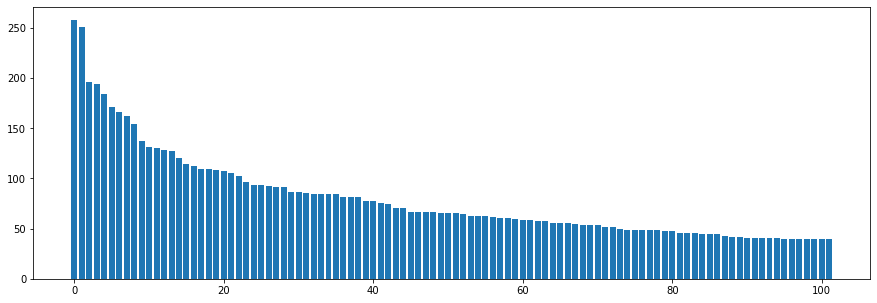

In [9]:
# Check class balance in full dataset
df['count_of_labels'] = df['label'].map(df['label'].value_counts())
df.sort_values(by='count_of_labels', inplace=True, ascending=False)
plt.figure(figsize =(15, 5))
plt.bar([i for i in range(max(df['label']))], df.drop_duplicates('label')['count_of_labels'], width = 0.8)
plt.show()

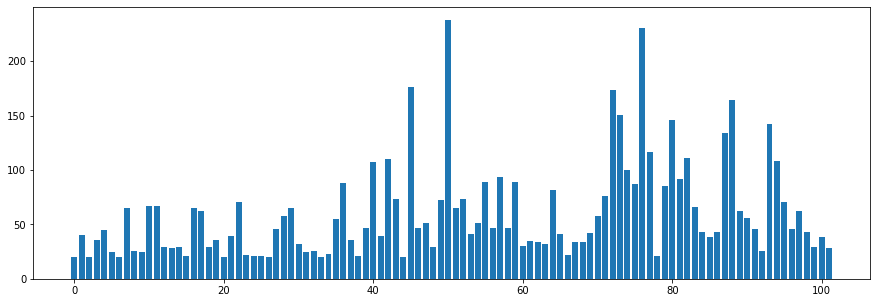

In [10]:
# Check class balance in train
train['count_of_labels'] = train['label'].map(train['label'].value_counts())
plt.figure(figsize =(15, 5))
plt.bar(train['label'], train['count_of_labels'], width = 0.8)
plt.show()

We can see that the training dataset is unbalanced, so we need to do something against it

<center style='color: green; font-size: 40px; font-family: "Lucida Console", Monaco, monospace;'>Prepare images</center>

We will normalize the images the same way we do on ImageNet images, because here we will be doing transfer learning

In [11]:
# Create some augmentation sqripts 
img_tform_0 = torch.nn.Sequential(
    transforms.Resize((480, 480)),    # Resize image for model, because model input is 480 * 480 pixels image 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize image like ImageNet
)

img_tform_1 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.RandomPerspective(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

img_tform_2 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

img_tform_3 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomErasing(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


img_tform_4 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

img_tform_5 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

img_tform_6 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

img_tform_7 = torch.nn.Sequential(
    transforms.Resize((480, 480)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [12]:
# Create train dataset
class FellowShipDataset(Dataset):
    def __init__(self, csv_file, root_dir, augment=img_tform_0):
        self.annotation = csv_file
        self.root_dir = root_dir
        self.augment = augment
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotation.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotation.iloc[index, 1]))
        image = self.to_tensor(image)
        image = self.augment(image)
        return (image, y_label)

# Create validation dataset
class ValidFellowShipDataset(Dataset):
    def __init__(self, csv_file, root_dir, augment=img_tform_0):
        self.annotation = csv_file
        self.root_dir = root_dir
        self.augment = augment
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotation.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotation.iloc[index, 1]))
        image = self.to_tensor(image)
        image = self.augment(image)
        return (image, y_label)

# Create test dataset
class TestFellowShipDataset(Dataset):
    def __init__(self, csv_file, root_dir, augment=img_tform_0):
        self.annotation = csv_file
        self.root_dir = root_dir
        self.augment = augment
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotation.iloc[index, 0])
        image = io.imread(img_path)
        y_label = None
        image = self.to_tensor(image)
        image = self.augment(image)
        return image

In [13]:
# Set hyperparameters
num_classes = 102
learning_rate = 4e-3
batch_size = 32
num_epochs = 10
root_dir_path = 'jpg'
csv_file_trn = train
csv_file_val = valid

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# Create DataLoader
def create_dataloaders(csv_file_train=csv_file_trn, csv_file_valid=csv_file_val, root_dir=root_dir_path, batch_size=batch_size):
    
    # Use augmentation
    train_data_0 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir)
    train_data_1 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_1)
    train_data_2 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_2)
    train_data_3 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_3)
    train_data_4 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_4)
    train_data_5 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_5)
    train_data_6 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_6)
    train_data_7 = FellowShipDataset(csv_file=csv_file_train, root_dir=root_dir, augment=img_tform_7)
    train_final = ConcatDataset([train_data_0, train_data_1, train_data_2, train_data_3,
                                 train_data_4, train_data_5, train_data_6, train_data_7])
    
    # Make train batches
    train_loader = torch.utils.data.DataLoader(train_final, batch_size=batch_size, shuffle=True)
    
    # Create validation
    val_data = ValidFellowShipDataset(csv_file=csv_file_valid, root_dir=root_dir)
    
    # Make validatoin batches
    valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [15]:
# Info about number of batches and number of images
train_loader, valid_loader = create_dataloaders(csv_file_train=csv_file_trn, csv_file_valid=csv_file_val, root_dir=root_dir_path, batch_size=batch_size)
train_size = len(train_loader)
print(f'Batches: {train_size}')
print(f'Images: {train_size*batch_size}')

Batches: 1538
Images: 49216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


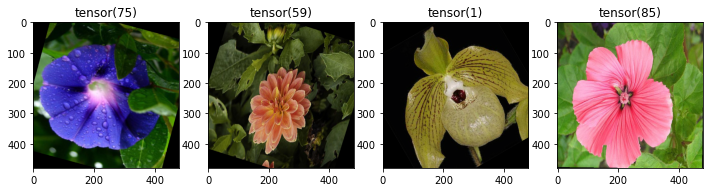

In [16]:
# Show some images
images, labels = next(iter(train_loader))

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

rows = 1
columns = 4
fig=plt.figure(figsize =(12, 6))
for i in range(4):
    fig.add_subplot(rows, columns, i+1)
    plt.title(labels[i])
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)

I chose EfficientNet_v2, because its quick and very accuracy. In my opinion, its one of the best models for projects like this
<br>EfficientNetV2 models are smaller and faster than most state-of-the-art models. This CNN model shows that even though Vision Transformers have taken the computer vision world by storm, by getting higher accuracies than other CNNs, better-structured CNN models with improved training methods can still achieve faster and better results than transformers, further proving that CNNs are here to stay.

We have small dataset and different from the pre-trained model's dataset, so we need to freeze first layers with low level features, and train mid level and high level features layers. But I didn't have enought vram, so I'll train only high level features and classifier

In [17]:
# Transfer model and freeze part of feature block and make new classifier block
model = torchvision.models.efficientnet_v2_m(weights='IMAGENET1K_V1')
layers_freeze = 8

model.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(1280, num_classes)
)

# train some layers and leave other frozen
for i in range(layers_freeze):
    for param in model.features[i].parameters():
        param.requires_grad = False

model.to(device);

In [18]:
# Train function
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device, epoch):
    model.train() 
    final_loss = 0  
    train_acc = 0
    total = 0
    train_preds=[]
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for batch_idx, (features, labels) in loop:
        optimizer.zero_grad()
        inputs, targets = features.to(device), labels.to(device)    # get images and labels
        outputs = model(inputs)    # get predicts
        loss = loss_fn(outputs, targets)    # get loss
        loss.backward()  
        optimizer.step()  
        scheduler.step() 
        total += len(targets)    # calculate total of predicted images
        final_loss += loss.item()    # calculate final loss of epoch
        _, predicted = torch.max(outputs, 1)    # get predict with highest chance
        train_acc += ((predicted == targets).sum().item())    # calculate number of true predictions of batch
        loop.set_description(f'Epoch: [{epoch+1}/{num_epochs}]')    
        loop.set_postfix(loss=final_loss/(batch_idx+1), acc=train_acc/total*100)
    final_loss /= len(dataloader)
    train_acc = (train_acc / total) * 100
    
    return final_loss, train_acc

In [19]:
# Valid function
def valid_fn(model, loss_fn, dataloader, device, epoch):
    model.eval() 
    final_loss = 0
    valid_preds = []
    val_acc = 0
    total = 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for batch_idx, (features,labels) in loop:
        inputs, targets = features.to(device), labels.to(device)    # get images and labels
        outputs = model(inputs)    # get predicts
        loss = loss_fn(outputs, targets)    # get loss
        total += len(targets)    # calculate total of predicted images
        final_loss += loss.item()    # calculate final loss of epoch 
        _, predicted = torch.max(outputs, 1)    # get predict with highest chance
        val_acc += ((predicted == targets).sum().item())
        loop.set_description(f'Epoch: [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=final_loss/(batch_idx+1), acc=val_acc/total*100)
    final_loss /= len(dataloader)
    val_acc = (val_acc / total) * 100
    
    return final_loss, val_acc

In [20]:
def run_training(train_acc_lst, train_loss_lst, valid_acc_lst, valid_loss_lst, loss_weights):
    #using adam optimizer for optimization
    optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max = num_epochs, eta_min = 3e-4)
    loss_fn = nn.CrossEntropyLoss(weight=loss_weights)
    
    for epoch in range(num_epochs):
        start = time.time()
        train_loss, train_acc = train_fn(model, optimizer, scheduler, loss_fn, train_loader, device, epoch) #training loss and accuracy
        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss)
        val_loss, val_acc = valid_fn(model, loss_fn, valid_loader, device, epoch) #validation loss and accuracy
        valid_acc_lst.append(val_acc)
        valid_loss_lst.append(val_loss)
    
    print(f'Train finished!')
    print(f'Your last train accuracy is {train_acc_lst[-1]}%')

In [21]:
# Our dataset is unbalanced, so we can calculate weight for each class
weights = train.copy()
weights.sort_values('label', inplace=True)
weights.drop_duplicates('label', inplace=True)
n_samples = list(weights['count_of_labels'])
weights = [(max(n_samples)/x) for x in n_samples]
loss_weights = torch.FloatTensor(weights).to(device)

In [22]:
# Fit our model
train_acc_lst = []
train_loss_lst = []
valid_acc_lst = []
valid_loss_lst = []
run_training(train_acc_lst, train_loss_lst, valid_acc_lst, valid_loss_lst, loss_weights)

Train finished!
Your last train accuracy is 98.87176776711661%


<center style='color: green; font-size: 40px; font-family: "Lucida Console", Monaco, monospace;'>Check epochs history</center>

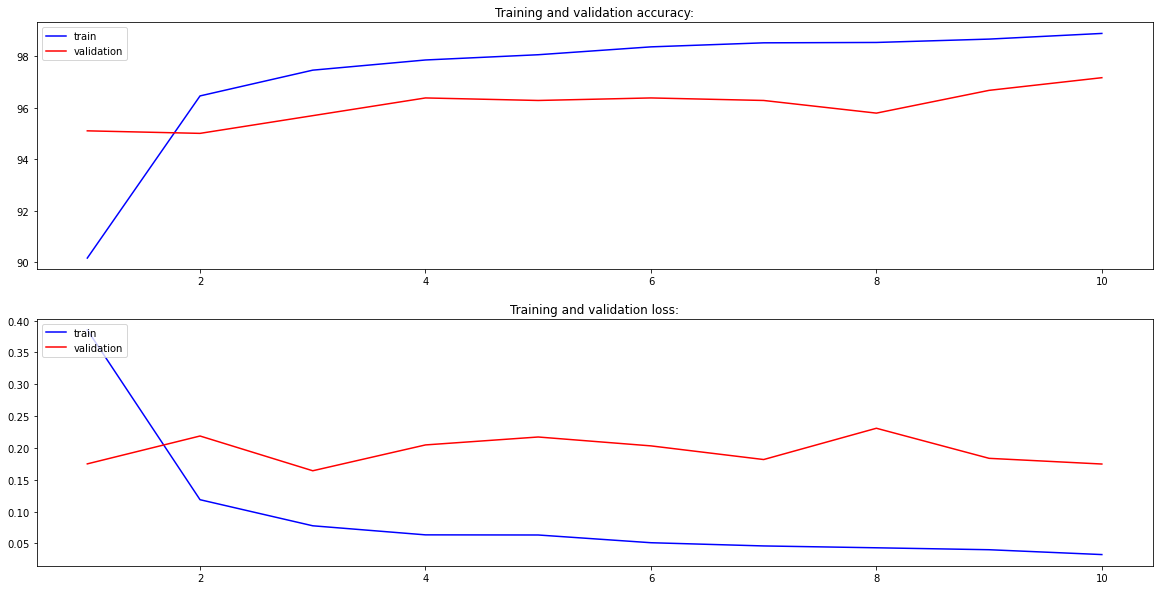

In [23]:
fix, ax = plt.subplots(2, figsize=(20, 10))
number_of_epochs = [i for i in range(1, num_epochs+1)]
ax[0].set_title('Training and validation accuracy:')
ax[0].plot(number_of_epochs, train_acc_lst, 'b', label='train')
ax[0].plot(number_of_epochs, valid_acc_lst, 'r', label='validation')
ax[0].legend(loc=2)
ax[1].set_title('Training and validation loss:')
ax[1].plot(number_of_epochs, train_loss_lst, 'b', label='train')
ax[1].plot(number_of_epochs, valid_loss_lst, 'r', label='validation')
ax[1].legend(loc=2)

<center style='color: green; font-size: 40px; font-family: "Lucida Console", Monaco, monospace;'>Check model on test data</center>

In [24]:
# Make predictions on test
test_pred = torch.Tensor()      
testdataset = TestFellowShipDataset(csv_file=test, root_dir=root_dir_path)    # get dataset
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=False)    # make batches
for features in testloader:
    features = features.to(device)
    outputs = model(features.float())    # predict
    _, predicted = torch.max(outputs, 1)
    test_pred = torch.cat((test_pred.to(device), predicted.to(device)), dim=0)
test['label'] = test_pred.cpu().numpy()
test.label = test.label.astype(int)

I use 4 different metrics: accuracy, precision, recall and matthews corr coeff.
<br>First three metrics is one of the most popular.
<br>The Accuracy is calculated using this formula: $\frac{TP + TN}{TP + TN + FP + FN}$
<br>The Precision is calculated using this formula: $\frac{TP}{TP + FP}$
<br>The Recall is calculated using this formula: $\frac{TP}{TP + FN}$<br>
<br>And the MCC metric one of the best metric for classification:
<br>The Matthews Corr Coeff is calculated using this formula: $\frac{TP*TN-FP*FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$<br>
<br>Accuracy is sensitive to class imbalance; precision, recall, and F1-score are asymmetric.<br>
<br>Some nice properties of MCC can be easily derived from this formula: when the classifier is perfect (FP = FN = 0) the value of MCC is 1, indicating perfect positive correlation. Conversely, when the classifier always misclassifies (TP = TN = 0), we get a value of -1, representing perfect negative correlation (in this case, you can simply reverse the classifier’s outcome to get the ideal classifier). In fact, MCC value is always between -1 and 1, with 0 meaning that the classifier is no better than a random flip of a fair coin. MCC is also perfectly symmetric, so no class is more important than the other; if you switch the positive and negative, you’ll still get the same value.

In [25]:
# Calculate some metrics
accuracy = Accuracy(task="multiclass", average='weighted', num_classes=num_classes)
precision = Precision(task="multiclass", average='weighted', num_classes=num_classes)
recall = Recall(task="multiclass", average='weighted', num_classes=num_classes)
matthews_corrcoef = MatthewsCorrCoef(task='multiclass', average='weighted', num_classes=num_classes)
preds = torch.tensor(test.label.values)
target = torch.tensor(true_test.label.values)
print(f'Accuracy: {accuracy(preds, target):.5}')
print(f'Precision: {precision(preds, target):.5}')
print(f'Recall: {recall(preds, target):.5}')
print(f'Matthews Corr Coeff: {matthews_corrcoef(preds, target):.5}')

Accuracy: 0.97157
Precision: 0.97525
Recall: 0.97157
Matthews Corr Coeff: 0.97132
